<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#House-Prices:-Advanced-Regression-Techniques" data-toc-modified-id="House-Prices:-Advanced-Regression-Techniques-1">House Prices: Advanced Regression Techniques</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2">Load Data</a></span><ul class="toc-item"><li><span><a href="#SalePrice-Target" data-toc-modified-id="SalePrice-Target-2.1">SalePrice Target</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3">Preprocessing</a></span></li></ul></div>

# House Prices: Advanced Regression Techniques

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

**Data size** : 1,460 observations and 80 features 

Name | Definition 
:---|:---
SalePrice | 	the property's sale price in dollars. This is the target variable that you're trying to predict.
MSSubClass| 	The building class
MSZoning| 	The general zoning classification
LotFrontage	| Linear feet of street connected to property
LotArea| 	Lot size in square feet
Street| 	Type of road access
Alley| 	Type of alley access
LotShape|  	General shape of property
LandContour| 	Flatness of the property
Utilities| 	Type of utilities available
LotConfig| 	Lot configuration
LandSlope| 	Slope of property
Neighborhood| 	Physical locations within Ames city limits
Condition1| 	Proximity to main road or railroad
Condition2| 	Proximity to main road or railroad (if a second is present)
BldgType| 	Type of dwelling
HouseStyle| 	Style of dwelling
OverallQual| 	Overall material and finish quality
OverallCond	| Overall condition rating
YearBuilt| 	Original construction date
YearRemodAdd| 	Remodel date
RoofStyle	| Type of roof
RoofMatl| 	Roof material
Exterior1st| 	Exterior covering on house
Exterior2nd| 	Exterior covering on house (if more than one material)
MasVnrType| 	Masonry veneer type
MasVnrArea| 	Masonry veneer area in square feet
ExterQual| 	Exterior material quality
ExterCond| 	Present condition of the material on the exterior
Foundation| 	Type of foundation
BsmtQual| 	Height of the basement
BsmtCond| 	General condition of the basement
BsmtExposure| 	Walkout or garden level basement walls
BsmtFinType1| 	Quality of basement finished area
BsmtFinSF1| 	Type 1 finished square feet
BsmtFinType2| 	Quality of second finished area (if present)
BsmtFinSF2| 	Type 2 finished square feet
BsmtUnfSF| 	Unfinished square feet of basement area
TotalBsmtSF	| Total square feet of basement area
Heating| 	Type of heating
HeatingQC| 	Heating quality and condition
CentralAir| 	Central air conditioning
Electrical| 	Electrical system
1stFlrSF| 	First Floor square feet
2ndFlrSF| 	Second floor square feet
LowQualFinSF| 	Low quality finished square feet (all floors)
GrLivArea| 	Above grade (ground) living area square feet
BsmtFullBath| 	Basement full bathrooms
BsmtHalfBath| 	Basement half bathrooms
FullBath| 	Full bathrooms above grade
HalfBath| 	Half baths above grade
Bedroom| 	Number of bedrooms above basement level
Kitchen	| Number of kitchens
KitchenQual| 	Kitchen quality
TotRmsAbvGrd| 	Total rooms above grade (does not include bathrooms)
Functional| 	Home functionality rating
Fireplaces| 	Number of fireplaces
FireplaceQu| 	Fireplace quality
GarageType| 	Garage location
GarageYrBlt| 	Year garage was built
GarageFinish| 	Interior finish of the garage
GarageCars| 	Size of garage in car capacity
GarageArea| 	Size of garage in square feet
GarageQual| 	Garage quality
GarageCond| 	Garage condition
PavedDrive| 	Paved driveway
WoodDeckSF| 	Wood deck area in square feet
OpenPorchSF| 	Open porch area in square feet
EnclosedPorch| 	Enclosed porch area in square feet
3SsnPorch| 	Three season porch area in square feet
ScreenPorch| 	Screen porch area in square feet
PoolArea| 	Pool area in square feet
PoolQC| 	Pool quality
Fence| 	Fence quality
MiscFeature| 	Miscellaneous feature not covered in other categories
MiscVal| 	$Value of miscellaneous feature
MoSold| 	Month Sold
YrSold| 	Year Sold
SaleType| 	Type of sale
SaleCondition| 	Condition of sale

**Reference**
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description

In [1]:
import sys 
sys.path.append('../code')

from loaddata import HousePriceData

import matplotlib.pyplot as plt

# Load Data

In [2]:
house_dataset = HousePriceData(file_path='../dataset/house_price/')

In [3]:
train_shape = house_dataset.data.shape
test_shape = house_dataset.testset.shape
print(f'Train set: {train_shape[0]} observations and {train_shape[1]} features')
print(f'Test set: {test_shape[0]} observations and {test_shape[1]} features')

Train set: 1460 observations and 81 features
Test set: 1459 observations and 80 features


In [4]:
house_dataset.data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## SalePrice Target

A `SalePrice` feature shows how much the house is worth.

The `SalePrice` feature shows a **right-skewd** distribution. 

In [10]:
house_dataset.data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

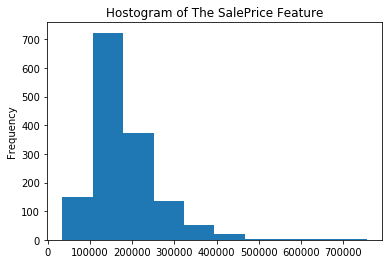

In [7]:
house_dataset.data.SalePrice.plot.hist(title='Hostogram of The SalePrice Feature')

# Preprocessing

I processed train and test set in four steps. This process applied in both the train and the test set.

1. Drop features that over 10% missing values.
2. Drop features that over 10 unique values.
3. Apply Log 1+ Transform to features that over 0.75 skewness.
4. Dummy transform to categorical features.

If you want to see this processing code, you can see in my github [code/loaddata.py](https://github.com/TooTouch/WhiteBox-Part2/blob/master/code/loaddata.py).

In [11]:
train, test = house_dataset.transform()
x_train, y_train = train

In [13]:
pretrain_shape = x_train.shape
pretest_shape = test.shape
print(f'pre-Train set: {pretrain_shape[0]} observations and {pretrain_shape[1]} features')
print(f'pre-Test set: {pretest_shape[0]} observations and {pretest_shape[1]} features')

pre-Train set: 1460 observations and 213 features
pre-Test set: 1459 observations and 213 features
